In [ ]:
import gzip
import random
import scipy
from collections import defaultdict
import re
import string

from gensim.models import Word2Vec
from nltk.stem.porter import *
from sklearn import linear_model
from sklearn.manifold import TSNE
from sklearn import linear_model
from implicit import bpr
from surprise import SVD, Reader, Dataset
from surprise.model_selection import train_test_split

In [2]:
def parseData(fname):
    for l in gzip.open(fname):
        d = eval(l)
        yield d

### User Reviews

In [6]:
user_reviews = list(parseData("australian_user_reviews.json.gz"))

In [ ]:
user_reviews[0]

In [31]:
[(x['item_id'],type(x['recommend']),x['review']) for x in user_reviews[0]['reviews']]

[('1250',
  bool,
  'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.'),
 ('22200', bool, "It's unique and worth a playthrough."),
 ('43110',
  bool,
  'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this game is definitely worth it and I hope they do a sequel...so buy the game so I get a sequel!')]

In [24]:
len(user_reviews)

25799

In [197]:
usersPerItem = defaultdict(set) 
itemsPerUser = defaultdict(set) 
reviewDict = {} 
helpful = []
helpfulDict = {}
reviewsText = {}

In [198]:
for user_review in user_reviews:
    reviews = [review for review in user_review['reviews']]
    for review in reviews:
        user, item = user_review['user_id'], review['item_id']
        usersPerItem[item].add(user)
        itemsPerUser[user].add(item)
        reviewDict[(user,item)] = 1 if review['recommend'] else 0
        reviewsText[(user,item)] = review['review']
        if review['helpful'] != 'No ratings yet':
            helpfulDict[(user,item)] = re.findall('(\d*)%',review['helpful'])[0]
        helpful.append(review['helpful'])

In [199]:
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)

In [200]:
for user_review in user_reviews:
    reviews = [review for review in user_review['reviews']]
    for review in reviews:
        user, item = user_review['user_id'], review['item_id']
        reviewsPerUser[user].append(review['review'])
        reviewsPerItem[item].append(review['review'])

In [201]:
len(helpfulDict)

28699

In [202]:
len(reviewDict) - len(helpfulDict)

29732

In [110]:
recommend = 0
dont_recommend = 0
for val in reviewDict.values():
    if val==1:
        recommend += 1
    else:
        dont_recommend += 1
        

In [111]:
recommend

51692

In [112]:
dont_recommend

6739

In [113]:
51692 + 6739

58431

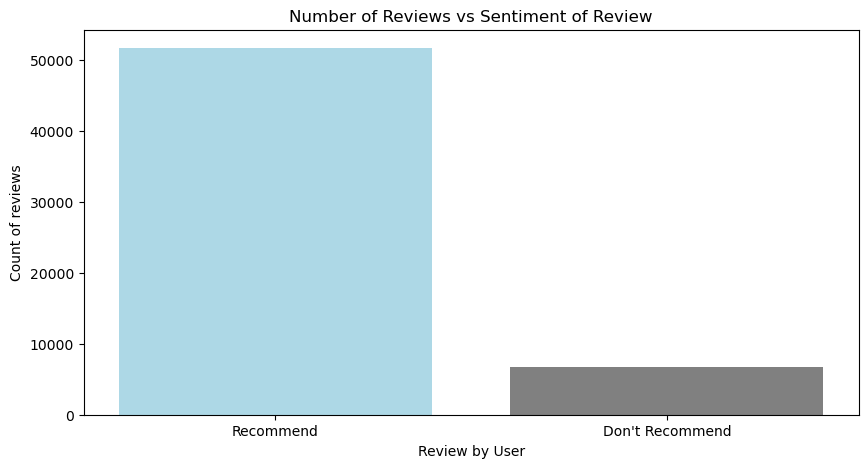

In [121]:
import numpy as np
import matplotlib.pyplot as plt
 
  
# creating the dataset
data = {'Recommend':recommend, "Don't Recommend":dont_recommend}
x = list(data.keys())
y = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(x, y, color =['lightblue','grey'])
 
plt.xlabel("Review by User")
plt.ylabel("Count of reviews")
plt.title("Number of Reviews vs Sentiment of Review")
plt.show()

#### Given the review text, classify if the user would have recommended or not recommended the game

In [295]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)

In [296]:
for reviewtext in list(reviewsText.values()):
    r = ''.join([c for c in reviewtext.lower() if not c in punctuation])
    for w in r.split():
            wordCount[w] += 1

counts = [(wordCount[w],w) for w in wordCount]
counts.sort()
counts.reverse()

In [297]:
words = [x[1] for x in counts[:2000]]

In [298]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [299]:
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum.lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

In [300]:
X = [feature(d) for d in list(reviewsText.values())]
y = [d for d in list(reviewDict.values())]

In [301]:
mod = linear_model.LogisticRegression(C=1,class_weight='balanced')
mod.fit(X,y)
predictions = mod.predict(X)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [217]:
len(predictions) - sum(predictions)

13167

In [302]:
correct = predictions == y
sum(correct) / len(correct)

0.8634800020537043

In [303]:
TP = sum([(p and l) for (p,l) in zip(predictions, y)])
FP = sum([(p and not l) for (p,l) in zip(predictions, y)])
TN = sum([(not p and not l) for (p,l) in zip(predictions, y)])
FN = sum([(not p and l) for (p,l) in zip(predictions, y)])

In [314]:
TP,FP,TN,FN

(44941, 1226, 5513, 6751)

In [315]:
TPR = TP / (TP + FN)
TNR = TN / (TN + FP)

In [316]:
BER = 1 - 1/2 * (TPR + TNR)
BER

0.15626329078013956

In [311]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)

In [312]:
precision, recall

(0.9734442350596747, 0.8693995202352395)

In [313]:
F1 = 2 * (precision*recall) / (precision + recall)
F1

0.918484758683412

In [306]:
correct = predictions == [1]*len(predictions)
sum(correct) / len(correct)

0.7901114134620322

In [308]:
correct = predictions == [0]*len(predictions)
sum(correct) / len(correct)

0.20988858653796785

#### Given the review text, classify if other users would have found it helpful or not helpful. If there is no data available, we can classify it as not helpful

In [244]:
X = [feature(d) for d in list(reviewsText.values())]
y = [1 if key in helpfulDict.keys() else 0 for key in reviewDict.keys()]

In [245]:
mod = linear_model.LogisticRegression(C=1,class_weight='balanced')
mod.fit(X,y)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1, class_weight='balanced')

In [246]:
predictions = mod.predict(X)

In [247]:
correct = predictions == y
sum(correct) / len(correct)

0.5733771456932107

In [248]:
correct = predictions == [1]*len(predictions)
sum(correct) / len(correct)

0.36365970118601426

In [249]:
correct = predictions == [0]*len(predictions)
sum(correct) / len(correct)

0.6363402988139857

### User Items

#### Bayesian Personalized Ranking (Implicit)


In [3]:
users_items = list(parseData("australian_users_items.json.gz"))

In [252]:
random.shuffle(users_items)

In [10]:
len(users_items)

88310

In [285]:
itemID2name = {}

In [286]:
userIDs,itemIDs = {},{}
for user_items in users_items:
    user = user_items['user_id']
    items = user_items['items']
    for item in items:
        if not user in userIDs: userIDs[user] = len(userIDs)
        itemID2name[len(itemIDs)] = item['item_name']
        if not item['item_name'] in itemIDs: itemIDs[item['item_name']] = len(itemIDs)
nUsers, nItems = len(userIDs), len(itemIDs)

In [280]:
nUsers, nItems

(70912, 10947)

In [266]:
Xiu = scipy.sparse.lil_matrix((nItems, nUsers))
for user_items in users_items:
    user = user_items['user_id']
    items = user_items['items']
    for item in items:
        Xiu[itemIDs[item['item_name']],userIDs[user]] = 1
    
Xui = scipy.sparse.csr_matrix(Xiu.T)

In [270]:
model = bpr.BayesianPersonalizedRanking(factors = 5)

In [271]:
model.fit(Xiu)

/opt/conda/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed lil_matrix instead. Converting to CSR took 0.045017242431640625 seconds
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

In [334]:
recommended = model.recommend(1, Xui[0])
related = model.similar_items(0)

In [335]:
recommended

(array([ 9152,  1505, 10455, 22923, 70235, 22689, 68554, 60317, 38557,
        23438], dtype=int32),
 array([3.192482 , 3.0767026, 3.060937 , 3.0302594, 2.9725742, 2.9597814,
        2.9394724, 2.9125116, 2.910664 , 2.89942  ], dtype=float32))

In [336]:
related

(array([    0, 20095, 67715,  5529, 29837, 31496, 37272, 70471, 58916,
        50807], dtype=int32),
 array([1.        , 0.986686  , 0.9866456 , 0.9858376 , 0.9826948 ,
        0.9812837 , 0.9798184 , 0.9775761 , 0.9768033 , 0.97485054],
       dtype=float32))

In [ ]:
related[0]

In [337]:
for idx in [0, 20095, 67715,  5529, 29837, 31496, 37272, 70471, 58916, 50807]:
    print(idx in itemID2name.keys())
    #print(itemID2name[idx])

True
False
False
True
False
False
False
False
False
False


#### Games

In [ ]:
games = list(parseData("steam_games.json.gz"))

In [ ]:
games[0]

{'publisher': 'Kotoshiro',
 'genres': ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy'],
 'app_name': 'Lost Summoner Kitty',
 'title': 'Lost Summoner Kitty',
 'url': 'http://store.steampowered.com/app/761140/Lost_Summoner_Kitty/',
 'release_date': '2018-01-04',
 'tags': ['Strategy', 'Action', 'Indie', 'Casual', 'Simulation'],
 'discount_price': 4.49,
 'reviews_url': 'http://steamcommunity.com/app/761140/reviews/?browsefilter=mostrecent&p=1',
 'specs': ['Single-player'],
 'price': 4.99,
 'early_access': False,
 'id': '761140',
 'developer': 'Kotoshiro'}

In [15]:
len(games)

32135

In [13]:
bundles = list(parseData("bundle_data.json.gz"))

In [319]:
itemsPerBundle = defaultdict(set)
bundleNames = {}
itemNames = {}

In [320]:
for bundle in bundles:
    bundle_id = bundle['bundle_id']
    bundleNames[bundle_id] = bundle['bundle_name']
    items = bundle['items']
    for item in items:
        itemsPerBundle[bundle_id].add(item['item_id'])
        itemNames[item['item_id']] = item['item_name']

In [322]:
itemsPerBundle['450']

{'326950',
 '331490',
 '331491',
 '331492',
 '348540',
 '352010',
 '387110',
 '387120',
 '390470',
 '394050',
 '396610',
 '396620',
 '398100',
 '408770'}

In [332]:
bundles[1]

{'bundle_final_price': '$20.15',
 'bundle_url': 'http://store.steampowered.com/bundle/1473/?utm_source=SteamDB&utm_medium=SteamDB&utm_campaign=SteamDB%20Bundles%20Page',
 'bundle_price': '$25.87',
 'bundle_name': 'Naruto Shippuden Uncut Season 4, Vol. 3',
 'bundle_id': '1473',
 'items': [{'genre': '',
   'item_id': '528360',
   'discounted_price': '$1.99',
   'item_url': 'http://store.steampowered.com/app/528360',
   'item_name': 'Naruto Shippuden Uncut: The Man Who Died Twice'},
  {'genre': '',
   'item_id': '528361',
   'discounted_price': '$1.99',
   'item_url': 'http://store.steampowered.com/app/528361',
   'item_name': 'Naruto Shippuden Uncut: The Worst Three-Legged Race'},
  {'genre': '',
   'item_id': '528362',
   'discounted_price': '$1.99',
   'item_url': 'http://store.steampowered.com/app/528362',
   'item_name': "Naruto Shippuden Uncut: Team 10's Teamwork"},
  {'genre': '',
   'item_id': '528363',
   'discounted_price': '$1.99',
   'item_url': 'http://store.steampowered.com/

In [339]:
all_bundle_ids = [bundle['bundle_id'] for bundle in bundles]

#### Recommending the most similar bundles

In [346]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [348]:
def mostSimilar(i, N):
    similarities = []
    items = itemsPerBundle[i]
    for i2 in itemsPerBundle:
        if i2 == i: continue
        sim = Jaccard(items, itemsPerBundle[i2])
        #sim = Pearson(i, i2) # Could use alternate similarity metrics straightforwardly
        similarities.append((sim,i2))
    similarities.sort(reverse=True)
    return similarities[:10]

In [351]:
ms = mostSimilar(all_bundle_ids[4], 10)

In [352]:
ms

[(0.0, '995'),
 (0.0, '990'),
 (0.0, '984'),
 (0.0, '983'),
 (0.0, '982'),
 (0.0, '977'),
 (0.0, '974'),
 (0.0, '972'),
 (0.0, '963'),
 (0.0, '962')]

In [ ]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer/denom
    return 0

In [ ]:
def mostSimilar(i, N):
    similarities = []
    users = usersPerItem[i]
    for i2 in usersPerItem:
        if i2 == i: continue
        sim = Jaccard(users, usersPerItem[i2])
        #sim = Pearson(i, i2) # Could use alternate similarity metrics straightforwardly
        similarities.append((sim,i2))
    similarities.sort(reverse=True)
    return similarities[:10]

In [ ]:
ms = mostSimilar(query, 10)

#### Bundle similarity based price estimation

In [358]:
itemsPerBundle = defaultdict(set)
bundlesPerItem = defaultdict(set)

In [359]:
bundlePrices = {}

In [357]:
for bundle in bundles:
    bundle_id = bundle['bundle_id']
    bundleNames[bundle_id] = bundle['bundle_name']
    bundlePrices[bundle_id] = bundle['bundle_final_price']
    items = bundle['items']
    for item in items:
        itemsPerBundle[bundle_id].add(item['item_id'])
        bundlesPerItem[item['item_id']].add(bundle_id)
        itemNames[item['item_id']] = item['item_name']

In [ ]:
def predictRating(user, bundle):
    prices = []
    similarities = []
    for d in itemsPerBundle[user]:
        i2 = d['product_id']
        if i2 == item: continue
        ratings.append(d['star_rating'] - itemAverages[i2])
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        # User hasn't rated any similar items
        return ratingMean

In [327]:
itemLists = []
for b in itemsPerBundle:
    il = list(itemsPerBundle[b])
    il.sort()
    itemLists.append(il)

In [330]:
model10 = Word2Vec(itemLists,
                 min_count=5, # Words/items with fewer instances are discarded
                 vector_size=10, # Model dimensionality
                 window=3, # Window size
                 sg=1) # Skip-gram model

In [345]:
for bundle_id in all_bundle_ids:
    try:
        for b in model10.wv.similar_by_word(bundle_id):
            print(bundleNames[b])
    except:
        pass

### Predict if a user will recommend a game

In [360]:
interactions = []

In [361]:
for user_review in user_reviews:
    reviews = [review for review in user_review['reviews']]
    for review in reviews:
        user, item = user_review['user_id'], review['item_id']
        review = 1 if review['recommend'] else 0
        interactions.append((user, item, review))

In [365]:
len(interactions)

59305

##### Baseline

In [363]:
gameCount = defaultdict(int)
totalRecommend = 0

for user,game,recommend in interactions:
    gameCount[game] += 1
    totalRecommend += 1

mostPopular = [(gameCount[x], x) for x in gameCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > totalRecommend/2: break

In [364]:
count

29748

In [375]:
ratingsValid = interactions[45000:]

In [ ]:
userSet = set()
gameSet = set()
recommendSet = set()

for u,g,r in interactions:
    userSet.add(u)
    gameSet.add(b)
    if r==1:
        recommendSet.add((u,b))

lUserSet = list(userSet)
lGameSet = list(gameSet)

notRecommend = set()
for u,g,r in interactions:
    u = random.choice(lUserSet)
    g = random.choice(lGameSet)
    while ((u,g) in recommendSet or (u,g) in notRecommend):
        g = random.choice(lGameSet)
    notRecommend.add((u,g))

recommendValid = set()
for u,g,r in interactions:
    recommendValid.add((u,g))

In [374]:
len(lUserSet)

25458

In [ ]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer/denom
    return 0

In [ ]:
correct = 0
p0, p1 = 0,0
for (label,sample) in [(1, readValid), (0, notRead)]:
    for (u,b) in sample:
        pred = 0
        if b in return1:
            pred = 1
        if pred == label:
            correct += 1

In [ ]:
correct / (len(readValid) + len(notRead))